## Fetching AHBA Data

In [ ]:
import abagen
from abagen import reporting
import nibabel as nib
import matplotlib.pyplot as plt 
import numpy as np

To obtain data from all available donors, pass in ```donors='all'``` instead of a donor list.

In [ ]:
files = abagen.fetch_microarray(donors=['9861', '10021'], verbose=0, data_dir='./data')

## Loading AHBA Data

#### See the Reference API on [abagen.io](https://abagen.readthedocs.io/en/latest/api.html#module-abagen.io) for a comprehensive list of functions that assist with loading ABHA data files.

In [ ]:
# List donor ID keys
print(files.keys())

# List the downloaded files available for donor 9861
sorted(files['9861'])

In [ ]:
# Print the annotation for donor 9861
data = files['9861']
annotation = abagen.io.read_annotation(data['annotation'])
annotation

In [ ]:
# Print the probes for donor 9861
probes = abagen.io.read_probes(data['probes'])
probes

## Parcellations

#### Demo Parcellation

```abagen.fetch_desikan_killiany``` will return a dictionary with two keys: 
1. ```image```: Filepath to a NIFTI image containing the atlas data.
2. ```info```: Filepath to a CSV file containing extra parcellation info.


In [ ]:
atlas = abagen.fetch_desikan_killiany()

im = nib.load(atlas['image'])

# Image type should be a 'nibabel.nifti1.Nifti1Image'
# print(type(im))

# View metadata
# print(im.header)

# Get the shape of the numpy array
im_data = im.get_fdata()
print(im_data.shape)

for i in range(10, len(im_data), 20):
    plt.imshow(im_data[i], cmap="bone")
    plt.axis('off')
    plt.show()

#### Individualized Parcellation

In [ ]:
atlas = abagen.fetch_desikan_killiany(native=True)

for key in atlas['image']:
    im = nib.load(atlas['image'][key])
    im_data = im.get_fdata()
    print(f"Donor {key}")
    plt.imshow(im_data[100], cmap="bone")
    plt.axis('off')
    plt.show()

## Parcellating Expression Data

#### See the [abagen docs](https://abagen.readthedocs.io/en/latest/user_guide/expression.html) for more information on parcellating expression data.

get_expression_data assigns [microarray](https://www.youtube.com/watch?v=NgRfc6atXQ8) gene expression data to the ROIs defined in the atlas['img'] argument. For our purposes, this is the Allen Human Brain atlas for each donor.

Matching of microarray samples to parcels in atlas is done via a [multi-step process](https://abagen.readthedocs.io/en/stable/generated/abagen.get_expression_data.html):
1. Determine if the sample falls directly within a parcel.

2. Check to see if there are nearby parcels by slowly expanding the search space to include nearby voxels, up to a specified distance (specified via the tolerance parameter).

3. If there are multiple nearby parcels, the sample is assigned to the closest parcel, as determined by the parcel centroid.

By default, data are normalized using a scaled robust [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) such that the expression values for a given gene will range from 0-1.
A value of 0 indicates the region with the lowest gene expression, while a value of 1 indicates the region with the highest.

Note that the generated pandas.DataFrame is an aggregate of the donor argument/s.

Interpreting the DataFrame:
- DataFrame rows correspond to region labels as defined in the atlas image.
- DataFrame columns correspond to genes.
- Entry values are microarray expression data normalized and aggregated across selected donors.

In [ ]:
# Use all donor image data
# expression = abagen.get_expression_data(atlas['image'])

# When using a volumetric image, it is recommended to include the additional information on the parcellation
# Note that the following function call loads all our specified donor data into memory, and will therefore be quite time-consuming
expression = abagen.get_expression_data(atlas['image'], atlas['info'], donors=['9861', '10021'])

expression

In [ ]:
# Note that some regions may not be matched to any tissue samples
nan_rows = expression.isna().any(axis=1)

for row, is_nan in nan_rows.items():
    if (is_nan):
        print(row, is_nan)

expression.loc[[18, 45]]

#### Ensuring a Dense Matrix

Microarray expression data may be missing (especially in right hemisphere regions), since not all donors have tissue samples for these areas.

abagen.get_expression_data() takes the following steps for each tissue sample:

1. Determine if the sample falls directly within a region of ```atlas```.
2. Check to see if the sample is close to any regions by slowly expanding the search space to include nearby voxels up to a particular threshold (specified using the ```tolerance``` parameter).
3. If there are multiple nearby regions, determine which region is closer by calculating the center-of-mass of the abutting reions.

Regions with no samples will have entry values of NaN. 
To resolve some/all empty entry values, we can utilize the two following techniques:
1. Use the ```missing``` parameter for localized data filling.
2. Duplicate samples across the main brain hemispheres with the ```lr_mirror``` parameter.

##### Using the ```missing``` Parameter

The ```missing``` parameter accepts three options:
1. ```None``` (default)
2. ```centroids```: Empty regions in the atlas will be assigned the expression values of the tissue sample falling closest to the centroid of that region. This is only done when all donors are missing data for a particular region. A weighted average of the matched samples are taken across donors, where the weights are calculated as the inverse distance between the tissue sample matched to the parcel centroid for each donor.
3. ```interpolate```: Expression values will be interpolated in the empty regions by assigning every node in the region the expression of the nearest tissue sample. This interpolation is done independently for every donor, irrespective of whether other donors have tissue samples that fall within a given region.

In [ ]:
# Setting the missing parameter will guarantee a dense expression matrix from an abagen.get_expression_data() function call
exp_centroids = abagen.get_expression_data(atlas['image'], atlas['info'], donors=['9861', '10021'], missing='centroids')

# Note that our NaN values have now been replaced with the nearest tissue expression values
exp_centroids.loc[[18, 45]]

##### Duplicating Samples with the ```lr_mirror``` Parameter

Most regions in the left hemisphere are likely to be matched to at least one sample, while right-hemisphere regions are less likely. The ```lr_mirror``` parameter allows samples to be mirrored acorss the left/right hemisphere axis. 
The following four options are available for ```lr_mirror```:
1. ```None``` (default)
2. ```bidirectional```: All available samples from the left hemisphere are duplicated and mirrored to the right, and vice-versa from right to left.
3. ```leftright```: Mirror only the left hemisphere to the right.
4. ```rightleft```: Mirror only the right hemisphere to the left.

In [ ]:
# The lr_mirror sample will not guarantee a dense matrix and will change the expression values of all regions, 
# not just those that are missing data
exp_mirror = abagen.get_expression_data(atlas['image'], atlas['info'], donors=['9861', '10021'], lr_mirror="bidirectional")

exp_mirror.loc[[18, 45]]

## Probe Selection

Probes can index the same gene, thereby causing redundant AHBA data. Probes can be selected and condensed to resolve redundancy using the ```probe_selection``` argument.
```probe_selection``` contains eight total options, though the ```differential stability``` (default) option is recommended by the official [abagen docs](https://abagen.readthedocs.io/en/stable/user_guide/probes.html).

#### Selecting a Representative Probe

The following methods select a single probe from each redundant group, based off a specific selection criteria:
- ```max_intensity```: Select the probe with the highest average expression across all samples.
- ```max_variability```: Select the probe with the highest variance in expression across all samples.
- ```pc_loading```: Select the probe with the highest loading value on the first principle component derived from the probe microarray expression.
- ```corr_intensity```: Select the probe with the highest correlation to other probes across all samples, using ```max_intensity``` as a fallback in the case of exactly two probes.
- ```corr_variance```: Select the probe with the highest correlation to other probes across all samples, using ```max_variance``` as a fallback in the case of exactly two probes.
- ```diff_stability```: Compute the [Spearman correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) of microarray expression values for each probe across brain regions for every pair of donors. The probe with the highest average correlation is selected.
- ```rnaseq```: Compute the Spearman correlation of microarray expression values for each probe across brain regions with RNAseq data for the corresponding gene. Only applies to RNAseq data donors 9861 and 10021.

In [52]:
# Example of representative probe selection
exp_pc_load = abagen.get_expression_data(atlas['image'], probe_selection='pc_loading')

KeyboardInterrupt: 

#### Collapsing Across Probes

An average for all probe expression values can be taken using the ```average``` parameter.

In [ ]:
exp_pc_load = abagen.get_expression_data(atlas['image'], probe_selection='average')

## Donor Aggregation with Probe Selection

By default, probe selection is performed using aggregated data across all donor samples. Donor-specific probe selection can be performed using the ```donor_probes``` argument, which takes the following three options:
1. ```aggregate```: Aggregate tissue samples across all donors and apply the selected ```probe_selection``` method to the aggregate sample matrix.
2. ```independent```: Perform the chosen ```probe_selection``` method for each donor seperately. Cannot be used with ```diff_stability```, ```rnaseq```, or ```average```.
3. ```common```: Perform the chosen ```probe_selection``` method for each donor, then use the most commonly-selected probe to represent each gene.

In [ ]:
exp_cmn_rna = abagen.get_expression_data(atlas['image'], donor_probes='common', probe_selection='rnaseq')

## Data Normalization

The abagen library supports nine options for dataset normalization, though the default ```scaled_robust_sigmoid``` option is recommended by the official [abagen docs](https://abagen.readthedocs.io/en/stable/user_guide/normalization.html). Data normalization options are as follows:
1. Centering: ```center```
2. Z-score: ```zscore```
3. Min-max: ```minmax```
4. Sigmoid: ```sigmoid```
5. Scaled Sigmoid: ```scaled_sigmoid```
6. Scaled Sigmoid Quantiles: ```scaled_sigmoid_quantiles```
7. Robust Sigmoid: ```robust_sigmoid```
8. Scaled Robust Sigmoid: ```scaled_robust_sigmoid```
9. Mixed Sigmoid: ```mixed_sigmoid```

Providing a value of ```None``` prevents data normalization.

Normalization can be accomplished in two directions: 
1. Each sample can be normalized across all genes (```gene_norm```).
2. Each sample can be normalized across all samples (```sample_norm```).

In [ ]:
# Use z-score normalization across all samples
exp_norm_zscore = abagen.get_expression_data(atlas['image'], sample_norm='zscore')

## Reporting

Based on the selected parameters, abagen can generate a report that details each processing step done to the AHBA dataset.

In [ ]:
report = reporting.Report(atlas['image'], atlas['info']).gen_report()
print(report)

## Probe Data

In [ ]:
files = abagen.fetch_microarray(donors='all', data_dir='./data')

In [ ]:
# Each donor file contains a probe count of 352,152
for donor in files:
    print(f"Donor {donor} probe count: {abagen.io.read_probes(files[donor]['probes']).size}")

## PCA & Clustering Analysis

See the following [365 Data Science](https://365datascience.com/tutorials/python-tutorials/pca-k-means/) guide for more information regarding PCA-based clustering.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [51]:
atlas = abagen.fetch_desikan_killiany()
expression = abagen.get_expression_data(atlas['image'], atlas['info'], donors=['9861', '10021'], missing='centroids')

c:\Users\umber\OneDrive\Documents\Research\minds\ahba\Lib\site-packages\abagen\probes_.py:147: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return io.read_microarray(microarray).groupby(sid, axis=1).mean()
c:\Users\umber\OneDrive\Documents\Research\minds\ahba\Lib\site-packages\abagen\probes_.py:147: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return io.read_microarray(microarray).groupby(sid, axis=1).mean()
c:\Users\umber\OneDrive\Documents\Research\minds\ahba\Lib\site-packages\abagen\allen.py:493: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  8   4   5   2   4  15   8  17   3   2   6   5   5  13   3   4   7   3
   2   9   5  14   1   2   6  15   6  20   5   2   2   5  28   7  17   6
   1  38   6   2   3   2   1   3  19   4  22   4   5   9   5   8  18   3
   7   2   3   4 

pandas.core.frame.DataFrame

Text(0, 0.5, 'A2M')

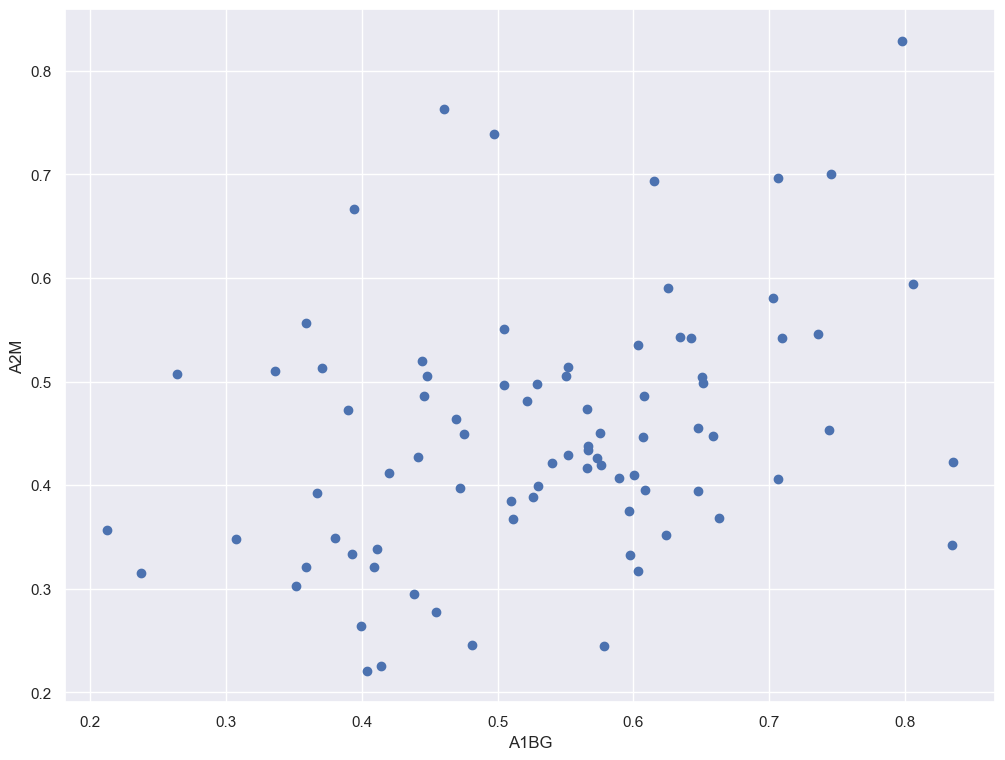

In [50]:
# Plot gene A2M with respect to gene A1BG
# Each data point corresponds to a parcellation
plt.figure(figsize=(12, 9))
plt.scatter(expression.iloc[:, 0], expression.iloc[:, 2])
plt.xlabel('A1BG')
plt.ylabel('A2M')

#### Data Preprocessing

In [ ]:
scaler = StandardScaler()
expression_std = scaler.fit_transform(expression)

#### PCA

In [ ]:
pca = PCA()
pca.fit(expression_std)
# Explains how much variance is explained by each component/gene
pca.explained_variance_ratio_

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(1, 84), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components (Genes)')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance (Cumulative)')

In [ ]:
# We'd like to capture ~80% of our variance, so we'll keep nine components
pca = PCA(n_components = 9)
pca.fit(expression_std)
scores_pca = pca.transform(expression_std)

# Fit K-Means using PCA data
wcss = []

N_CLUSTERS = 20
for i in range(1, N_CLUSTERS + 1):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 21)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(range(1, N_CLUSTERS + 1), wcss, marker = 'o', linestyle = '--')

In [ ]:
# Given the graph above, we'd like to keep seven clusters (see Elbow Method for K-means Clustering)
N_CLUSTERS = 7
kmeans_pca = KMeans(n_clusters = N_CLUSTERS, init='k-means++', random_state = 21)
kmeans_pca.fit(scores_pca)

In [ ]:
# Create a new data frame with the original features and add the PCA scores and assigned clusters
exp_pca_kmeans = pd.concat([expression.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
exp_pca_kmeans.columns.values[-9: ] = ['Component 1', 'Component 2', 'Component 3', 
                                       'Component 4', 'Component 5', 'Component 6', 
                                       'Component 7', 'Component 8', 'Component 9']

# Add the PCA K-means Clustering labels
exp_pca_kmeans['Expression K-Means PCA'] = kmeans_pca.labels_

In [ ]:
exp_pca_kmeans['Expression'] = exp_pca_kmeans['Expression K-Means PCA'].map({0:'first', 1:'second', 2:'third', 3:'fourth', 
                                                                            4:'fifth', 5:'sixth', 6:'seventh'})

In [ ]:
# Plot data using the two PCA components with largest variance
x_axis = exp_pca_kmeans['Component 2']
y_axis = exp_pca_kmeans['Component 1']
plt.figure(figsize=(10, 8))
sns.scatterplot(x = x_axis, y = y_axis, hue = exp_pca_kmeans['Expression'])
plt.title('Clusters by PCA Components')
plt.show()

## Nilearn Plotting

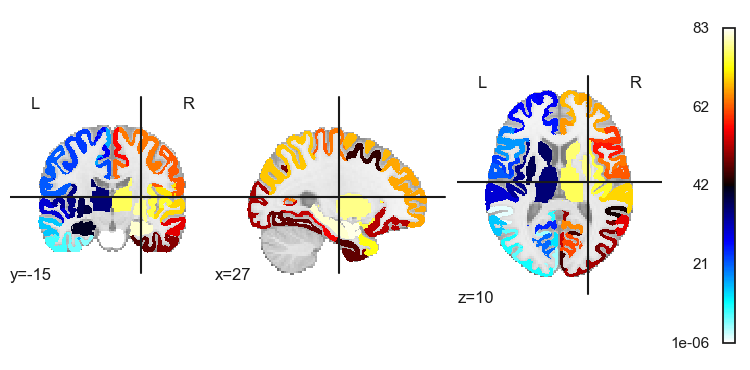

In [49]:
from nilearn.plotting import plot_stat_map

atlas = abagen.fetch_desikan_killiany()
im = nib.load(atlas['image'])

display = plot_stat_map(im)